## 訓練預測模型
在這個筆記本中，我們將訓練一個深度學習模型，該模型基於歷史價格數據，學習下一個交易日是否會觸及目標價格或止損價格，以進行多頭/空頭交易。

模型：
* 多層感知器（MLP）（前向神經網絡）
* 3層：輸入、隱藏、輸出
* 二元分類
* 輸入：收盤價，SMA（2到16），ROC（2到16）
* 輸出：在接下來的五天內，多頭或空頭交易是否觸及了2%的利潤目標，而未觸及1.5%的止損點？

In [1]:
%run ./init_model.py 'model_long_short_predict'

model_long_short_predict


In [2]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-2023-09'

In [3]:
import sys
!{sys.executable} -m pip install PyAthena

  Obtaining dependency information for PyAthena from https://files.pythonhosted.org/packages/1d/35/777bbc5f9e40d8d57967c2794993555e6e87d3a721ade44893252bccd6a9/pyathena-3.0.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 11.6 MB/s eta 0:00:00


In [4]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

In [5]:
import pandas as pd
from pyathena import connect
conn = connect(s3_staging_dir='s3://'+s3bucket+'/results/',
               region_name=region)

df = pd.read_sql("SELECT * FROM algo_data.hist_data_daily;", conn)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

/tmp/ipykernel_9595/721653243.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM algo_data.hist_data_daily;", conn)


,sym,open,high,low,close,vol
dt,,,,,,
2000-01-03,JNJ,93.13,93.75,91.69,92.19,2321200.0
2000-01-04,JNJ,91.13,91.56,88.75,88.81,3911100.0
2000-01-05,JNJ,88.81,90.81,88.44,90.19,4114800.0
2000-01-06,JNJ,90.31,93.94,90.13,92.56,2678200.0
2000-01-07,JNJ,94.13,96.94,93.63,96.50,4931900.0


In [6]:
df.to_csv('local/'+model_name+'/input/data/training/data_orig.csv')
print("count=%s" % len(df))
df.head()

count=5200


,sym,open,high,low,close,vol
dt,,,,,,
2000-01-03,JNJ,93.13,93.75,91.69,92.19,2321200.0
2000-01-04,JNJ,91.13,91.56,88.75,88.81,3911100.0
2000-01-05,JNJ,88.81,90.81,88.44,90.19,4114800.0
2000-01-06,JNJ,90.31,93.94,90.13,92.56,2678200.0
2000-01-07,JNJ,94.13,96.94,93.63,96.50,4931900.0


Matplotlib is building the font cache; this may take a moment.


<IPython.core.display.Javascript object>


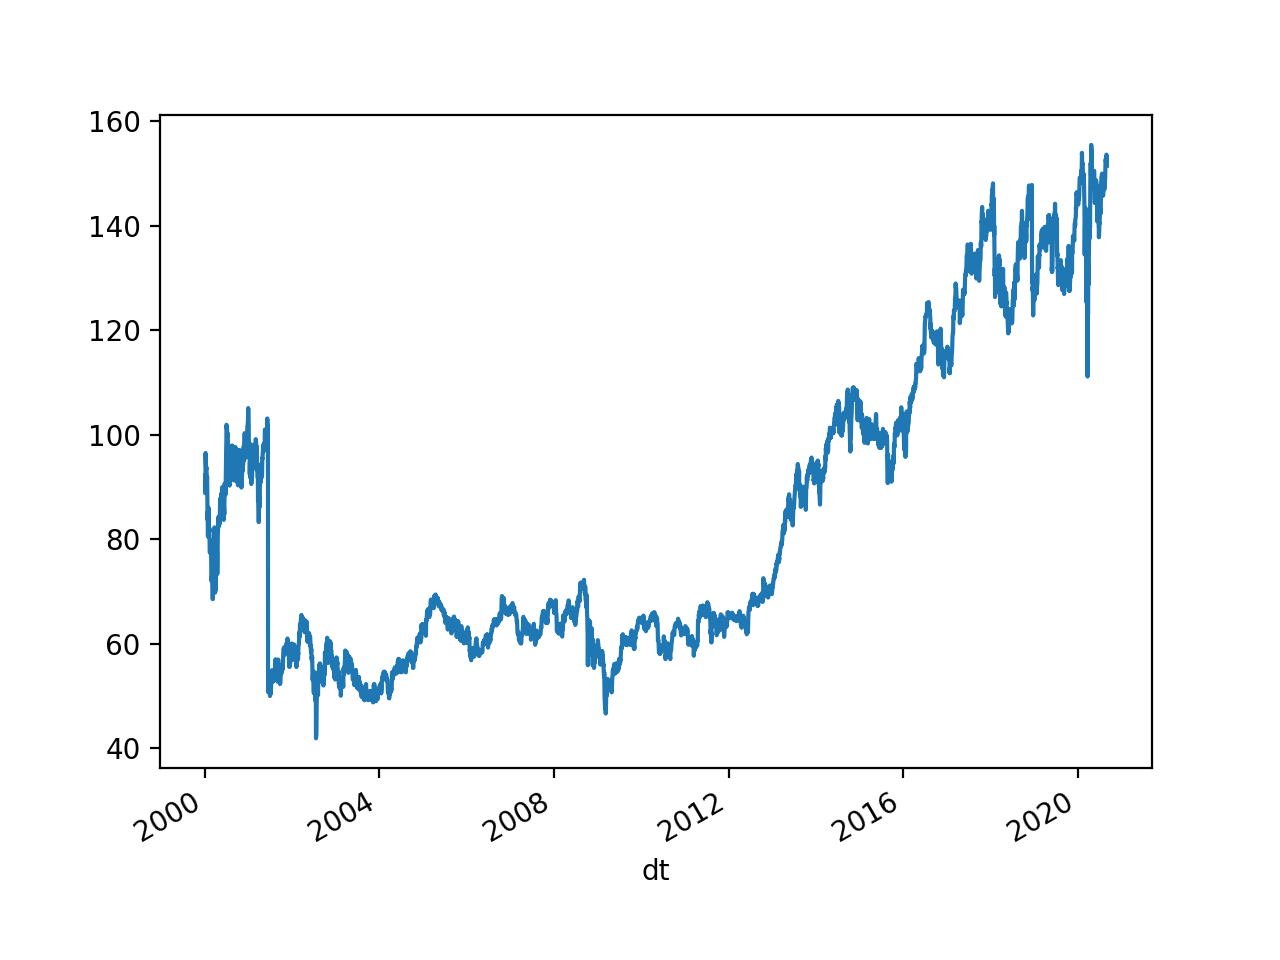

<Axes: xlabel='dt'>

In [7]:
%matplotlib notebook
df["close"].plot()

# Step 2) Run Data Preparation Locally

## Modify Data Preparation Code

In the following cell, you can modify the data preparation code or leave it as is.

In [13]:
%mkdir model

In [14]:
%%writefile model/{model_name}_prep.py
#!/usr/bin/env python

import numpy as np
import pandas as pd
import talib as ta
from talib.abstract import *
import math

prefix = '/opt/ml/'
input_path = prefix + 'input/data/training'

data_orig_file = input_path+'/data_orig.csv'
data_file = input_path+'/data.csv'

d = pd.read_csv(data_orig_file,infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print(d.head())

repeatCount=15
repeatStep=1
lookBack=repeatCount*repeatStep
forwardWindow=5

profitTarget=2.0/100.0
stopTarget=1.5/100.0

iCount=lookBack

# header
hData=["dt"]
hData.append("close")
for a in range(0,repeatCount):
    hData.append("sma"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("roc"+str((a+2)*repeatStep))
hData.append("long")
hData.append("short")

# data
tData=[]

inputs = {
    'close': np.array(d["close"])
}
sma=[]
for a in range(0,repeatCount):
    sma.append(SMA(inputs,timeperiod=(a+1)*repeatStep+1))
roc=[]
for a in range(0,repeatCount):
    roc.append(ROC(inputs,timeperiod=(a+1)*repeatStep+1))

closeList=d["close"]
dLen=len(d)
n=0
lCount=0
sCount=0
nCount=0
n=0
for idx,row in d.iterrows():
    if n<dLen-forwardWindow-1:
        dt1=idx
        cl=row["close"]
        inputRec=[]
        inputRec.append(idx)

        inputRec0=[]

        #close
        inputRec0.append(cl)

        #sma
        for a in range(0,repeatCount):
            if math.isnan(sma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(sma[a][n])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,repeatCount):
            if math.isnan(roc[a][n]):
                inputRec.append(0)
            else:
                inputRec.append(roc[a][n])

        rClose=closeList[n+1:min(dLen-1,n+1+forwardWindow)].values.tolist()
        low=min(rClose)
        high=max(rClose)
        
        #long
        long=0
        if high>=cl+cl*profitTarget and low>=cl-cl*stopTarget:
            long=1
            lCount=lCount+1
        inputRec.append(long)
 
        #short
        short=0
        if low<=cl-cl*profitTarget and high<=cl+cl*stopTarget:
            short=1
            sCount=sCount+1
        inputRec.append(short)

        tData.append(inputRec)
        n=n+1
          
print("lCount=%s,sCount=%s" % (lCount,sCount))
df1=pd.DataFrame(tData,columns=hData)
df1.set_index(pd.DatetimeIndex(df1['dt']), inplace=True)
del df1['dt']
 
df1.to_csv(data_file)
print(df1.head())
print("count=%s" % (len(df1)))

Writing model/model_long_short_predict_prep.py


## Run Data Preparation Locally in a Docker Container

In [17]:
!cp model/{model_name}_prep.py model/train
!chmod 777 model/train
!docker build -t {model_name}_prep .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name}_prep train

Sending build context to Docker daemon  4.008MB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 737b6f070f7f
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> f190ab67a79e
Step 4/21 : RUN pip install numpy
 ---> Using cache
 ---> 2bfc5ca70386
Step 5/21 : RUN pip install scipy
 ---> Using cache
 ---> 9e70f31a276a
Step 6/21 : RUN pip install scikit-learn
 ---> Using cache
 ---> 6678cf1bb921
Step 7/21 : RUN pip install pandas
 ---> Using cache
 ---> 6af058476183
Step 8/21 : RUN pip install flask
 ---> Using cache
 ---> d09d7ac

## Create Training and Test Data

In [18]:
df = pd.read_csv("local/"+model_name+"/input/data/training/data.csv", infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print("totalCount=%s" % len(df))

trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]
dfTrain.to_csv("local/"+model_name+"/input/data/training/data_train.csv")
print("trainCount=%s" % len(dfTrain))

dfTest = df.iloc[trainCount:]
dfTest.to_csv("local/"+model_name+"/input/data/training/data_test.csv")
print("testCount=%s" % len(dfTest))
dfTest.head()

/tmp/ipykernel_9595/1995880456.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("local/"+model_name+"/input/data/training/data.csv", infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])


totalCount=5194
trainCount=2077
testCount=3117


,close,sma2,sma3,sma4,sma5,sma6,sma7,sma8,sma9,sma10,...,roc9,roc10,roc11,roc12,roc13,roc14,roc15,roc16,long,short
dt,,,,,,,,,,,,,,,,,,,,,
2008-04-09,0.985554,1.000000,0.947030,0.821830,0.658106,0.555377,0.559046,0.441413,0.276083,0.186196,...,2.584339,2.457496,2.695585,2.157497,1.391863,2.173243,1.500536,3.513429,0,0
2008-04-10,1.000000,0.979937,0.983281,0.939812,0.831473,0.682341,0.581549,0.576176,0.460536,0.298809,...,3.349953,2.646240,2.519320,2.757552,2.219140,1.453044,2.234895,1.561782,0,0
2008-04-11,0.717506,0.915853,0.965940,1.000000,0.977160,0.879790,0.731244,0.625845,0.618666,0.492712,...,1.741945,2.835774,2.135562,2.009274,2.246321,1.710587,0.948302,1.726264,0,0
2008-04-14,0.442133,0.624963,0.840609,0.934369,0.999062,1.000000,0.918296,0.776150,0.671843,0.667155,...,-0.197358,1.341144,2.430664,1.733210,1.607419,1.843532,1.309909,0.550627,0,0
2008-04-15,0.297760,0.373516,0.544667,0.769127,0.890335,0.979558,1.000000,0.929055,0.787832,0.681587,...,0.520594,-0.333991,1.202405,2.290433,1.593934,1.468315,1.704105,1.171213,1,0


# Step 3) Train the Model

In the following cell, you can modify the model training code or leave it as is.

In [ ]:
%%writefile model/{model_name}.py
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import traceback
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

yLen=2
b=0

# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your
# container.
prefix = '/opt/ml/'

input_path = prefix + 'input/data/training/data_train.csv'
test_path = prefix + 'input/data/training/data_test.csv'

output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

# Process and prepare the data
def data_process(df):
    global yLen
    global b
    dataX=[]
    dataY=[]
    for idx,row in df.iterrows():
        row1=[]
        r=row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x=np.array(row1)
        y=np.array(row[len(row)-yLen:])
        b=len(x)
        dataX.append(x)
        dataY.append(y)
    dataX=np.array(dataX).astype(np.float32)
    dataY=np.array(dataY).astype(np.float32)
    return dataX,dataY,b

def build_classifier():
    global b
    global yLen
    print("build_classifier:b=%s,yLen=%s" % (b,yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_model(dataX, dataY, b):
    model=build_classifier()
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return model
        
def train():
    print('Starting the training.')
    try:
        raw_data = pd.read_csv(input_path)
        #print(raw_data)
        X, y, b = data_process(raw_data)
        model = generate_model(X, y, b)
        model.save(os.path.join(model_path, 'model.h5'))
        
        print('Training is complete. Model saved.')
        
        raw_data = pd.read_csv(test_path)
        testX, testY, b = data_process(raw_data)
        scores = model.evaluate(testX, testY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

### Train Locally

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [ ]:
# Build Local ML Image
!cp model/{model_name}.py model/train
!chmod 777 model/train
!docker build -t {model_name} .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name} train

In [ ]:
!ls -la local/{model_name}/model/model.h5
!cp local/{model_name}/model/model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la ../2_Strategies/model/model_*.h5